# Imports

In [8]:
import sys

from category_encoders.target_encoder import TargetEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import rfpimp
from rfpimp import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sys.path.append('../')
from utils import feature_imp

In [2]:
%reload_ext autoreload
%autoreload 2

# Load Data

In [4]:
df = pd.read_csv('../data/rent.csv', parse_dates=['created'])
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,['https://photos.renthop.com/2/7211212_1ed4542...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"['Doorman', 'Elevator', 'Fitness Center', 'Cat...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,['https://photos.renthop.com/2/7150865_be3306c...,5465,808 Columbus Avenue
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"['Laundry In Building', 'Dishwasher', 'Hardwoo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,['https://photos.renthop.com/2/6887163_de85c42...,2850,241 W 13 Street
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"['Hardwood Floors', 'No Fee']",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,['https://photos.renthop.com/2/6888711_6e660ce...,3275,333 East 49th Street
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,['Pre-War'],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,['https://photos.renthop.com/2/6934781_1fa4b41...,3350,500 West 143rd Street


In [5]:
df.shape

(49352, 15)

# Cleaning

In [6]:
# Cleaning
df_clean = df[(df['price'] > 1_000) & (df['price'] < 10_000)]
df_clean = df_clean[(df_clean['longitude'] != 0) | (df_clean['latitude'] != 0)]
criteria = ((df_clean['latitude'] > 40.55) &
            (df_clean['latitude'] < 40.94) &
            (df_clean['longitude'] > -74.1) &
            (df_clean['longitude'] < -73.67))
df_clean = df_clean[criteria]
df = df_clean
df.shape

(48300, 15)

# Baseline

In [7]:
num_feat = ['bathrooms', 'bedrooms', 'latitude', 'longitude']
y = df.pop('price')
X = df[num_feat]

In [12]:
def test(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob_score = rf.oob_score_
    num_nodes = rfpimp.rfnnodes(rf)
    height = np.median(rfpimp.rfmaxdepths(rf))
    print(f'OOB R^2 {oob_score:.5f} using {num_nodes:,d} tree nodes & '
          f'{height} median tree height.')
    return rf, oob_score

In [13]:
rf, oob_score = test(X, y)

OOB R^2 0.86787 using 2,431,718 tree nodes & 35.0 median tree height.


In [14]:
def show_imp(rf, X, y):
    feat = X.columns.values.tolist()
    feat.remove('longitude')
    feat.remove('latitude')
    # Since both long and lat represents a location property
    feat += [['longitude', 'latitude']]
    imp = importances(rf, X, y, features=feat)
    plot_importances(imp)

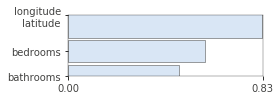

In [15]:
show_imp(rf, X, y)

# Encoding Categorical Features

## Ordinal Categorical Features

The feature ordinal is ordinal since we can rank and compare values.

In [16]:
df['interest_level'].value_counts()

low       33270
medium    11203
high       3827
Name: interest_level, dtype: int64

In [17]:
# Convert to categorical then numericalize it
df['interest_level'] = df['interest_level'].astype('category')
df['interest_level'].cat.reorder_categories(['low', 'medium', 'high'], inplace=True)
df['interest_level'] = df['interest_level'].cat.codes + 1
df.interest_level.value_counts()

1    33270
2    11203
3     3827
Name: interest_level, dtype: int64

In [18]:
X = df[num_feat + ['interest_level']]
rf, oob_score = test(X, y)

OOB R^2 0.87053 using 3,026,268 tree nodes & 35.0 median tree height.


A little bit of improvement over the baseline while the complexity of the typical tree stayed the same (height of the tree). Note that this improvement may be random.

## Nominal Categorical Features

Nominal features are categorical features that don't have orders and no difference between the space of the each value

In [19]:
df['manager_id'].nunique(), df['building_id'].nunique(), df['display_address'].nunique()

(3409, 7417, 8679)

As we can see, all the above feature have high cardinality (large number of unique values).

### Label Encoding

Numericalize the features and ignoring the ordering of those features --> Don't interpret values as ordered.

In [20]:
# Convert to categorical then numericalize it
df['display_address_cat'] = df['display_address'].astype('category').cat.as_ordered()
df['display_address_cat'] = df['display_address_cat'].cat.codes + 1

In [21]:
X = df[num_feat + ['display_address_cat']]
rf, oob_score = test(X, y)

OOB R^2 0.86583 using 3,121,248 tree nodes & 37.0 median tree height.


There is no improvement in $R^2$ and the complexity of RF increased.

### Frequency Encoding

Convert the nominal features to the frequency of each category that they appeared in the training dataset.

In [22]:
mgrs_count = df['manager_id'].value_counts()
df['mgr_apt_count'] = df['manager_id'].map(mgrs_count)

In [23]:
mgrs_count

e6472c7237327dd3903b3d6f6a94515a    2509
6e5c10246156ae5bdcd9b487ca99d96a     695
8f5a9c893f6d602f4953fcc0b8e6e9b4     404
62b685cc0d876c3a1a51d63a0d6a8082     396
cb87dadbca78fad02b388dc9e8f25a5b     370
                                    ... 
64b495eb63c39b0bd692c8b11d142048       1
6f27a49688fea09958c6325fa09eb7f8       1
81d08815507f8d30d6b23e951d4fbb7b       1
e2ab97ca9d7619d7c6d040252260b9bf       1
8e62f602c0a251577abeb2411f889401       1
Name: manager_id, Length: 3409, dtype: int64

In [24]:
X = df[num_feat + ['display_address_cat', 'mgr_apt_count']]
rf, oob_score = test(X, y)

OOB R^2 0.86409 using 4,569,082 tree nodes & 41.0 median tree height.


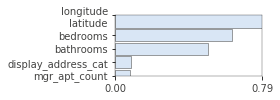

In [25]:
show_imp(rf, X, y)

There is no improvement in $R^2$ and the complexity of RF increased. Don't include those features.

# Encoding Text/String Features

Those kind of features are not numerical or categorical.

In [26]:
# Normalizing the features
df['description'] = df['description'].fillna('')
df['description'] = df['description'].str.lower() # normalize to lower case
df['features'] = df['features'].fillna('') # fill missing w/blanks
df['features'] = df['features'].str.lower() # normalize to lower case

In [27]:
# has apartment been renovated?
df['renov'] = df['description'].str.contains('renov')

for w in ['doorman', 'parking', 'garage', 'laundry', 
          'Elevator', 'fitness center', 'dishwasher']:
    df[w] = df['features'].str.contains(w)
df[['doorman', 'parking', 'garage', 'laundry']].head(5)

,doorman,parking,garage,laundry
0,False,False,False,False
1,True,False,False,False
2,False,False,False,True
3,False,False,False,False
4,False,False,False,False


In [28]:
df['num_desc_words'] = df['description'].apply(lambda x: len(x.split()))
df['num_features'] = df['features'].apply(lambda x: len(x.split(',')))
df['num_photos'] = df['photos'].apply(lambda x: len(x.split(',')))

In [29]:
text_feat = [
    'num_photos', 'num_desc_words', 'num_features',
    'doorman', 'parking', 'garage', 'laundry', 
    'Elevator', 'fitness center', 'dishwasher',
    'renov'
]
X = df[text_feat + num_feat]
rf, oob = test(X, y)

OOB R^2 0.86220 using 4,767,554 tree nodes & 43.0 median tree height.


Again, the above generated features from text features did not improve (a little bit deteriorated) with noticeable complexity increase.

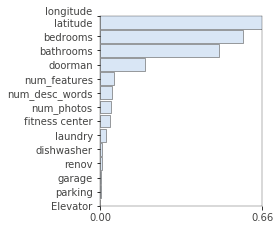

In [30]:
show_imp(rf, X, y)

# Synthesizing Numeric Features

In [31]:
df["beds_to_baths"] = df["bedrooms"] / (df["bathrooms"] + 1)
X = df[['beds_to_baths'] + num_feat]
rf, oob_score = test(X, y)

OOB R^2 0.86758 using 2,433,468 tree nodes & 35.0 median tree height.


# Target Encoding Categorical Features

The idea is to take the average of the target variable by category for any categorical feature.

In [32]:
# Split the data into train and test sets
df_train, df_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

X_train = df_train[num_feat]
X_val = df_val[num_feat]

In [33]:
# Baseline
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
val_score = rf.score(X_val, y_val)
print(f'validation R^2 = {val_score:4f}. {rfnnodes(rf):,d} tree nodes & '
      f'{np.median(rfmaxdepths(rf))} median tree height.')

validation R^2 = 0.860438. 2,131,064 tree nodes & 34.5 median tree height.


In [35]:
# Target Enconding
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
encoder = TargetEncoder(cols=['building_id'])
df_train_encoded = encoder.fit_transform(df_train, y_train)
df_val_encoded = encoder.transform(df_val, y_val)

In [36]:
df_train_encoded.head()

,index,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,...,parking,garage,laundry,Elevator,fitness center,dishwasher,num_desc_words,num_features,num_photos,beds_to_baths
0,13835,1.0,0,3232.823529,2016-06-09 01:39:07,,West 34th Street,"['doorman', 'fitness center', 'elevator', 'cat...",1,40.7494,...,False,False,True,False,True,False,0,7,1,0.000000
1,16035,2.0,3,2611.695210,2016-06-12 07:09:00,,West End Avenue,"['cats allowed', 'dogs allowed']",1,40.7901,...,False,False,False,False,False,False,0,2,1,1.000000
2,36346,1.0,0,3435.865735,2016-06-12 06:50:18,forest hills is a great little neighbo...,62nd Road,['elevator'],1,40.7271,...,False,False,False,False,False,False,76,1,3,0.000000
3,28218,2.0,4,3052.030193,2016-05-24 02:36:01,available for immediate occupancy. awesome tre...,Attorney St.,"['pre-war', 'dogs allowed', 'cats allowed']",1,40.7200,...,False,False,False,False,False,False,85,3,6,1.333333
4,3509,1.0,2,3567.210718,2016-04-26 04:59:02,,East 5th Street,"['cats allowed', 'dogs allowed', 'exclusive']",1,40.7261,...,False,False,False,False,False,False,0,3,1,1.000000


In [37]:
X_train = df_train_encoded[num_feat + ['building_id']]
X_val = df_val_encoded[num_feat + ['building_id']]

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
val_score = rf.score(X_val, y_val)
print(f'validation R^2 = {val_score:4f}. {rfnnodes(rf):,d} tree nodes & '
      f'{np.median(rfmaxdepths(rf))} median tree height.')

validation R^2 = 0.862162. 2,369,340 tree nodes & 37.0 median tree height.


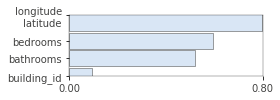

In [38]:
show_imp(rf, X_train, y_train)

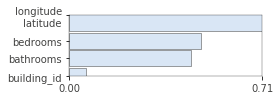

In [39]:
show_imp(rf, X_val, y_val)

The score improved a little bit and the importance figures showed that the target_encoded feature is the least important feature. However, many practitioners found it useful in other datasets.

# Adding External Data Sources

We will use the proximity to the top 10 neighborhoods in NY city as numerical features. We will compute the Manhattan Distance to compute the proximity for each row from the top 10 neighborhoods.

In [41]:
top_10_neighborhoods = {
    'hells' : [40.7622, -73.9924],
    'astoria' : [40.7796684, -73.9215888],
    'Evillage' : [40.723163774, -73.984829394],
    'Wvillage' : [40.73578, -74.00357],
    'LowerEast' : [40.715033, -73.9842724],
    'UpperEast' : [40.768163594, -73.959329496],
    'ParkSlope' : [40.672404, -73.977063],
    'Prospect Park' : [40.93704, -74.17431],
    'Crown Heights' : [40.657830702, -73.940162906],
    'financial' : [40.703830518, -74.005666644],
    'brooklynheights' : [40.7022621909, -73.9871760513],
    'gowanus' : [40.673, -73.997]
}

In [42]:
for hood in top_10_neighborhoods:
    for hood, loc in top_10_neighborhoods.items():
        df[hood] = np.abs(df['latitude'] - loc[0]) + np.abs(df['longitude'] - loc[1])

In [43]:
X = df[num_feat + list(top_10_neighborhoods.keys())]
rf, oob_score = test(X, y)

OOB R^2 0.87218 using 2,412,936 tree nodes & 43.0 median tree height.


A little bit of improvement over the baseline with increased in complexity.

# Final Model

Let's combine all the features we created and see how the model performs.

In [44]:
X = df[['interest_level'] + num_feat + text_feat + list(top_10_neighborhoods.keys())]
rf, oob_score = test(X, y)

OOB R^2 0.87951 using 4,836,552 tree nodes & 43.0 median tree height.


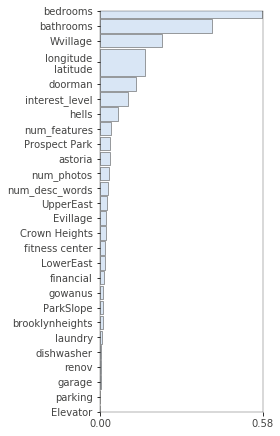

In [45]:
show_imp(rf, X, y)

The improvement in relative accuracy of the final model over the just the numerical features (baseline model) is:

In [46]:
print(f'{(oob_score - 0.86778) / (1 - 0.86778):.4%}')

8.8739%
